In [1]:
import numpy as np
from glob import glob
import pandas as pd 
import SimpleITK as itk
from math import floor

from skimage import morphology, measure
from skimage.transform import resize

from time import sleep
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
mhd_list = glob('./correct_images/*.mhd')
def find_file(name):
    for f in mhd_list:
        if f == './correct_images/{}.mhd'.format(name):
            return f
    return None

annotations = pd.read_csv('./csv/train/annotations.csv')
annotations['file'] = annotations['seriesuid'].apply(find_file)
annotations.dropna(inplace=True)
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,file
628,LKDS-00052,29.438147,63.496942,-196.670914,5.209168,./correct_images/LKDS-00052.mhd
629,LKDS-00052,-100.509793,29.321020,-97.178042,5.062185,./correct_images/LKDS-00052.mhd
630,LKDS-00052,-119.283954,-23.223688,-110.817716,8.679782,./correct_images/LKDS-00052.mhd
631,LKDS-00052,-89.668593,34.299059,-128.560248,23.483745,./correct_images/LKDS-00052.mhd
632,LKDS-00052,-75.732970,35.285004,-185.380144,4.181188,./correct_images/LKDS-00052.mhd


In [9]:
def draw(img, title='', point=None, diameter=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    if point is not None:
        plt.scatter(point[0], point[1],  c='w', s=diameter*10, edgecolors='r', alpha=0.2)
    plt.title(title)
    plt.show()

In [10]:
def get_slice_img(img_array, tumor, origin, spacing):
    # origin in world coordinates (mm)
    pos = np.array([tumor['coordX'], tumor['coordY'], tumor['coordZ']])
    # nodule center in voxel space
    pos = np.round((pos - origin) / spacing)
    # diameter in voxel space
    diameter = tumor['diameter_mm'] / spacing[0]

    img = img_array[int(pos[2])]
    point = [-pos[0], -pos[1]]
    draw(img, title='origin img', point=point, diameter=diameter)
    
    mean, std = np.mean(img), np.std(img)
    img = (img - mean) / std
    draw(img, title='mean/std img', point=point, diameter=diameter)
    
    mask = img.copy()
    mean = np.mean(mask[100:400, 100:400]) # lung part means
    min_color, max_color = np.min(mask), np.max(mask)
    mask[mask==min_color] = 0 #better than mean
    mask[mask==max_color] = mean
    
    # learn from kmeans
#     mask = np.where(mask >= 0.4874, 1.0, 0.0)
    kmeans = KMeans(n_clusters=2).fit(np.reshape(mask, ( np.prod(mask.shape) , 1) ))
    threshold = np.mean(kmeans.cluster_centers_)
#     print('threshold: {}'.format(threshold))
    mask = np.where(mask>=threshold, 1.0, 0.0)
    draw(mask, title='Kmeans slice')
    
    # [4, 4] and [24, 24] are got by many trials
    mask = morphology.dilation(mask, np.ones([4, 4]))
    draw(mask, title='dilation')
    mask = morphology.erosion(mask, np.ones([24, 24]))
    draw(mask, title='erosion')
    
    # background=1 is a hack, prevent regard 0 as background...
    labeled_mask = measure.label(mask, background=1)
    regions = measure.regionprops(labeled_mask)
    
    lung_labels = []
    new_min_row, new_min_col, new_max_row, new_max_col = 99999, 99999, -99999, -99999
    for region in regions:
        min_row, min_col, max_row, max_col = region.bbox
        if min_row > 100 and min_col > 20 and max_row < 450 and max_col < 450:
            lung_labels.append(region.label)
            
            if new_min_row > min_row:
                new_min_row = min_row
            if new_min_col > min_col:
                new_min_col = min_col
            if new_max_row < max_row:
                new_max_row = max_row
            if new_max_col < max_col:
                new_max_col = max_col
        
    if len(lung_labels) == 0:
        print('length of lung_labels == 0; continue;')
        return (None, None)
    
    mask = np.ndarray([512,512], dtype=np.int8)
    mask[:] = 0
    for label in lung_labels:
        mask += np.where(labeled_mask==label, 1, 0)
    
#     mask = morphology.dilation(mask,np.ones([4, 4]))
    draw(mask, title='img outline mask')
    
#     new_mean = np.mean(img[mask>0])
#     new_std = np.std(img[mask>0])
#     old_min = np.min(img) # background
#     img[img==old_min] = new_mean - 5 * new_std
#     img = (img - new_mean) / new_std

    img = img * mask
    draw(img, title='img covered by mask', point=point, diameter=diameter)
    
    origin_shape = img.shape
    MAX_ROW = origin_shape[0]
    MAX_COL = origin_shape[1]
    
    row_gap = new_max_row - new_min_row
    col_gap = new_max_col - new_min_col
    if row_gap > col_gap:
        inc = row_gap - col_gap
        if new_max_col + inc < MAX_COL:
            new_max_col += inc
        else:
            new_min_col -= (new_max_col + inc - MAX_COL)
            new_max_col = MAX_COL
    else:
        inc = col_gap - row_gap
        if new_max_row + inc < MAX_ROW:
            new_max_row += inc
        else:
            new_min_row -= (new_max_row + inc - MAX_ROW)
            new_max_row = MAX_ROW

    img = img[new_min_row:new_max_row, new_min_col:new_max_col]
    img = resize(img, output_shape=origin_shape, mode='constant')

    point = [-pos[0], -pos[1]]
    
    point[0] -= new_min_col
    point[1] -= new_min_row
    resize_factor = (new_max_col - new_min_col) / MAX_COL
    point = [v / resize_factor for v in point]
    diameter /= resize_factor
    draw(img, title='final transformed img', point=point, diameter=diameter)
    
    ###### till now, img got #####
    
    # tumor_mask, 5 pixel margin
    tumor_mask = np.zeros(img.shape)
    min_row = max(0, int(point[1] - diameter - 5))
    min_col = max(0, int(point[0] - diameter - 5))
    max_row = min(512, int(point[1] + diameter + 5))
    max_col = min(512, int(point[0] + diameter + 5))
    for r in range(min_row, max_row):
        for c in range(min_col, max_col):
            # 欧几里得距离
            if np.linalg.norm(np.array(point) - np.array([c, r])) <= diameter:
                tumor_mask[r, c] = 1.0
    draw(tumor_mask, title='tumor_mask')
    
    return img, tumor_mask

In [ ]:
all_slices = []
all_mask = []

img_array = None
tumor = None

for f in mhd_list:
    print('processing {}'.format(f))
    itk_img = itk.ReadImage(f)
    origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    img_array = itk.GetArrayFromImage(itk_img)

    tumors = annotations[annotations.file == f]
    for i in range(tumors.shape[0]):
        tumor = tumors.iloc[i]
        
        img, tumor_mask = get_slice_img(img_array, tumor, origin, spacing)
        
        if img is not None and tumor_mask is not None:
            all_slices.append(img)
            all_mask.append(tumor_mask)
            print('tumor {} done'.format(i+1))
            
#         break
#     break

X_train = np.reshape(all_slices, (-1, 1, 512, 512))
y_train = np.reshape(all_mask, (-1, 1, 512, 512))

np.save('X_train', X_train)
np.save('y_train', y_train)

print("X_train, y_tain saved")

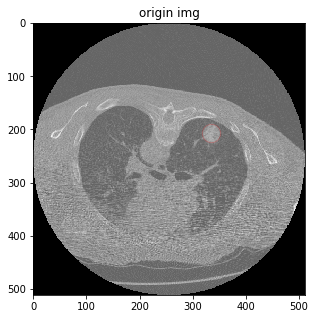

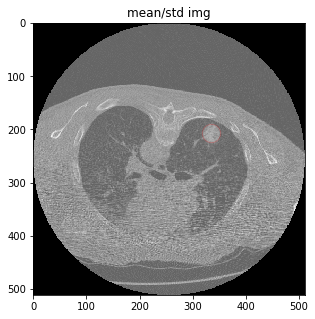

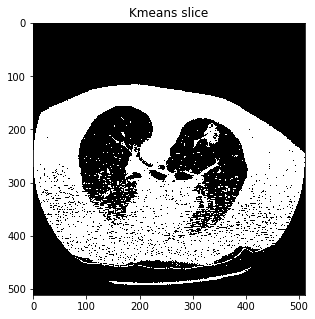

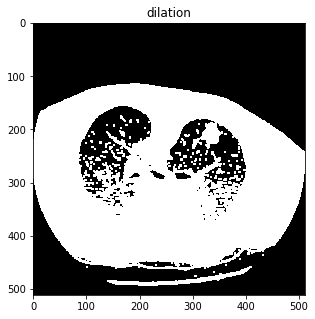

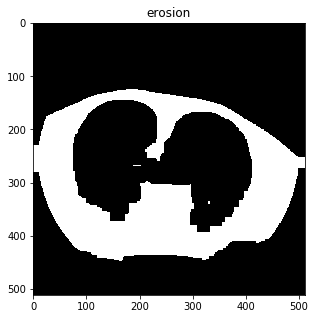

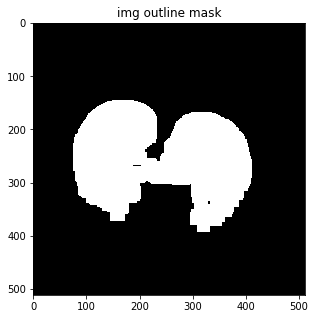

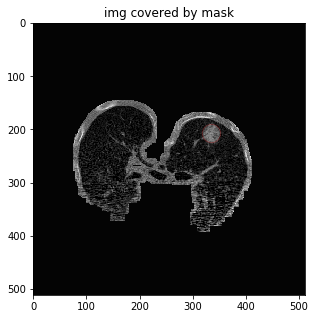

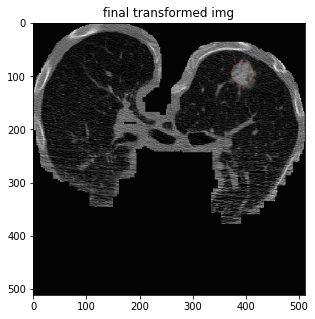

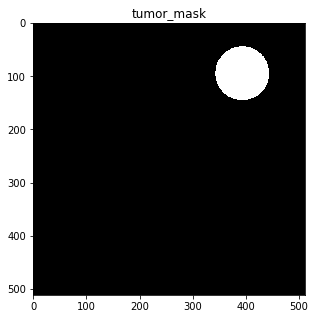

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0., -0., -0., ..., -0., -0.,  0.],
        [ 0., -0., -0., ..., -0., -0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

In [11]:
# let's draw and see
get_slice_img(img_array, tumor, origin, spacing)

In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

img_rows = 512
img_cols = 512
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_coef_np(y_true,y_pred):
#     y_true_f = y_true.flatten()
#     y_pred_f = y_pred.flatten()
#     intersection = np.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def get_unet():
    inputs = Input((1, img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    #       Conv2D(32, (3, 3), activation="relu", padding="same")

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

model = get_unet()
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 512, 512)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 512, 512)  320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 32, 512, 512)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 32, 256, 256)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [ ]:
model_checkpoint = ModelCheckpoint(filepath='unet-model-{epoch:02d}.hdf5', 
                                   monitor='loss', verbose=1, save_best_only=True)
model.fit(X_train, y_train, batch_size=2, epochs=1, verbose=1, shuffle=True, callbacks=[model_checkpoint])

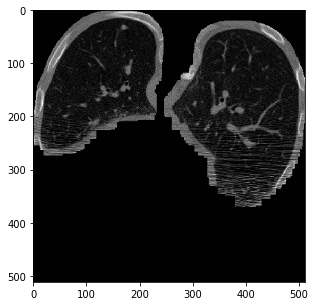

In [34]:
draw(X_train[0].reshape((512,512)))

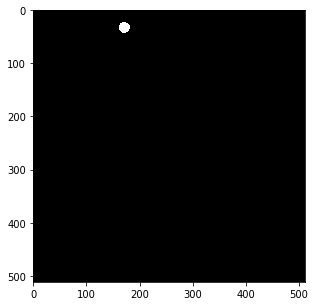

In [33]:
#model.load_weights('unet-model-32.hdf5')
#y_pred = model.predict(np.expand_dims(X_train[0], axis=0))
draw(y_train[0].reshape((512,512)))

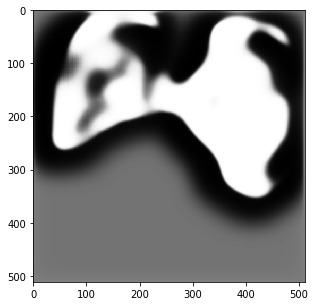

In [29]:
# load trained model weights in cloud GPU
model.load_weights('unet-model-28.hdf5')
y_pred = model.predict(np.expand_dims(X_train[0], axis=0))
draw(y_pred[0].reshape((512,512)))

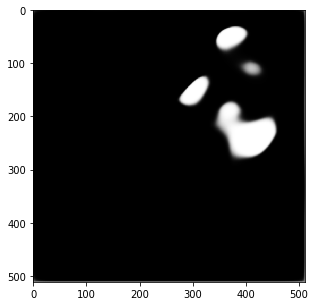

In [32]:
model.load_weights('unet-model-32.hdf5')
y_pred = model.predict(np.expand_dims(X_train[0], axis=0))
draw(y_pred[0].reshape((512,512)))